First, ensure all required packages have been imported

In [ ]:
!pip3 install -U tensorflow_addons

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow_addons-0.14.0-cp36-cp36m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Using cached tensorflow_addons-0.13.0-cp36-cp36m-manylinux2010_x86_64.whl (679 kB)
  Using cached tensorflow_addons-0.12.1-cp36-cp36m-manylinux2010_x86_64.whl (703 kB)
  Using cached tensorflow_addons-0.12.0-cp36-cp36m-manylinux2010_x86_64.whl (703 kB)
  Using cached tensorflow_addons-0.11.2-cp36-cp36m-manylinux2010_x86_64.whl (1.1 MB)
  Using cached tensorflow_addons-0.11.1-cp36-cp36m-manylinux2010_x86_64.whl (1.1 MB)
  Using cached tensorflow_addons-0.11.0-cp36-cp36m-manylinux2010_x86_64.whl (1.1 MB)
  Using cached tensorflow_addons-0.10.0-cp36-cp36m-manylinux2010_x86_64.whl (1.0 MB)
  Using cached tensorflow_addons-0.

In [ ]:
# inbuilt imports
import os
import glob
import pathlib
import tempfile
import functools

# numeric imports
import numpy as np
import pandas as pd

# visual imports
import matplotlib.pyplot as plt

# modeling imports
import tensorflow as tf
import tensorflow_addons as tfa

%matplotlib inline

Establish path to data

In [ ]:
base_path = pathlib.Path('..')
path = pathlib.Path('/home/zhoo0005/sc73/ranzcr-clip-catheter-line-classification')

Import train data csv file

In [ ]:
train = pd.read_csv("/home/zhoo0005/sc73/ranzcr-clip-catheter-line-classification/train.csv")
train

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30078,1.2.826.0.1.3680043.8.498.74257566841157531124...,0,0,1,0,0,0,0,0,1,1,0,5b5b9ac30
30079,1.2.826.0.1.3680043.8.498.46510939987173529969...,0,0,0,0,0,0,0,0,0,1,0,7192404d8
30080,1.2.826.0.1.3680043.8.498.43173270582850645437...,0,0,1,0,0,1,0,1,0,1,0,d4d1b066d
30081,1.2.826.0.1.3680043.8.498.95092491950130838685...,0,0,0,0,0,0,0,0,1,0,0,01a6602b8


Reduce image size and batch size to reduce computing time while renaming column names

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 16

all_labels = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 
              'NGT - Abnormal', 'NGT - Borderline','NGT - Incompletely Imaged', 
              'NGT - Normal', 'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal', 
              'Swan Ganz Catheter Present']

# Brief EDA on data
Length of data set

In [ ]:
len(train)

30083

How many unique patients we have

In [ ]:
len(train.PatientID.unique())

3255

Set the patient ID as the index

In [ ]:
ID_index_df = train.set_index('PatientID')

ID_index_df.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
PatientID,,,,,,,,,,,,
ec89415d1,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0
bf4c6da3c,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0
3fc1c97e5,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0
c31019814,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0
207685cd1,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0


A look at the recordings from 1 patient

In [ ]:
ID_index_df.loc['ec89415d1'].sort_values(by=['StudyInstanceUID'])

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
PatientID,,,,,,,,,,,,
ec89415d1,1.2.826.0.1.3680043.8.498.12069601668869166279...,0,0,0,0,0,1,0,0,0,1,0
ec89415d1,1.2.826.0.1.3680043.8.498.13669042249425506984...,0,0,0,0,0,0,1,0,1,0,0
ec89415d1,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0
ec89415d1,1.2.826.0.1.3680043.8.498.34482941866634300538...,0,0,0,0,0,0,0,1,0,0,0
ec89415d1,1.2.826.0.1.3680043.8.498.58735051192792195566...,0,0,0,0,0,0,0,0,1,0,0
ec89415d1,1.2.826.0.1.3680043.8.498.76602365606870209106...,0,0,0,0,1,0,0,0,1,0,0


In [ ]:
train['Image'] = train['StudyInstanceUID'].map(lambda x: str(path/'train'/(x+'.jpg')))
print(train.loc[0, ['Image']].values)

['/home/zhoo0005/sc73/ranzcr-clip-catheter-line-classification/train/1.2.826.0.1.3680043.8.498.26697628953273228189375557799582420561.jpg']


# Splitting into train and test

In [ ]:
grouped_df = train.groupby('PatientID')

train_list = [group for _, group in grouped_df]

In [ ]:
def train_valid_splitter(d, train_size=0.8):
    n = len(d)
    trains = d[:int(train_size*n)]
    valids = d[int(train_size*n):]
    return trains, valids

train_split, valid_split = train_valid_splitter(train_list)
train_df = pd.concat(train_split, axis=0)
valid_df = pd.concat(valid_split, axis=0)

print(f'Train Size: {len(train_df)}, Testing Size: {len(valid_df)}')

Train Size: 24100, Testing Size: 5983


In [ ]:
train_df

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID,Image
15388,1.2.826.0.1.3680043.8.498.59892784756152007438...,0,0,0,0,0,0,0,1,0,0,0,003e65ddb,/home/zhoo0005/sc73/ranzcr-clip-catheter-line-...
26606,1.2.826.0.1.3680043.8.498.99288640270596999784...,0,0,0,0,0,0,0,0,0,1,0,003e65ddb,/home/zhoo0005/sc73/ranzcr-clip-catheter-line-...
26736,1.2.826.0.1.3680043.8.498.24106277096191278042...,0,0,0,0,0,0,0,1,0,0,0,003e65ddb,/home/zhoo0005/sc73/ranzcr-clip-catheter-line-...
11171,1.2.826.0.1.3680043.8.498.48867760618674148489...,0,0,0,0,0,0,0,0,1,0,0,00757839e,/home/zhoo0005/sc73/ranzcr-clip-catheter-line-...
16045,1.2.826.0.1.3680043.8.498.42161315615619527946...,0,0,0,0,0,0,0,0,0,1,0,00757839e,/home/zhoo0005/sc73/ranzcr-clip-catheter-line-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,1.2.826.0.1.3680043.8.498.35342516979031910596...,0,0,0,0,0,0,0,0,0,1,0,cff48b351,/home/zhoo0005/sc73/ranzcr-clip-catheter-line-...
6027,1.2.826.0.1.3680043.8.498.29151406117761819957...,0,0,0,0,0,0,0,0,0,1,0,cff48b351,/home/zhoo0005/sc73/ranzcr-clip-catheter-line-...
15510,1.2.826.0.1.3680043.8.498.10464763505639233965...,0,0,0,0,0,0,0,0,1,0,0,cff48b351,/home/zhoo0005/sc73/ranzcr-clip-catheter-line-...
26603,1.2.826.0.1.3680043.8.498.12245783950654018071...,0,0,0,0,0,0,0,0,0,1,0,cff48b351,/home/zhoo0005/sc73/ranzcr-clip-catheter-line-...


In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=0.40
)

train_datagen = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image',
    y_col=all_labels,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=42,
    class_mode='raw'
)

Found 24100 validated image filenames.


In [ ]:
valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

valid_datagen = valid_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Image',
    y_col=all_labels,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=42,
    class_mode='raw'
)

Found 5983 validated image filenames.


In [ ]:
def display_batch(batch, n_imgs=9):
    r = int(n_imgs**0.5)
    fig, axs = plt.subplots(r, r, figsize=(12, 15))
    imgs, labels = batch[0], batch[1]
    for i, ax in zip(range(n_imgs), axs.flatten()):
        title = '\n'.join(list(np.array(all_labels)[labels[i].flatten()==1]))
        ax.imshow(imgs[i], cmap='bone')
        ax.set_title(title)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

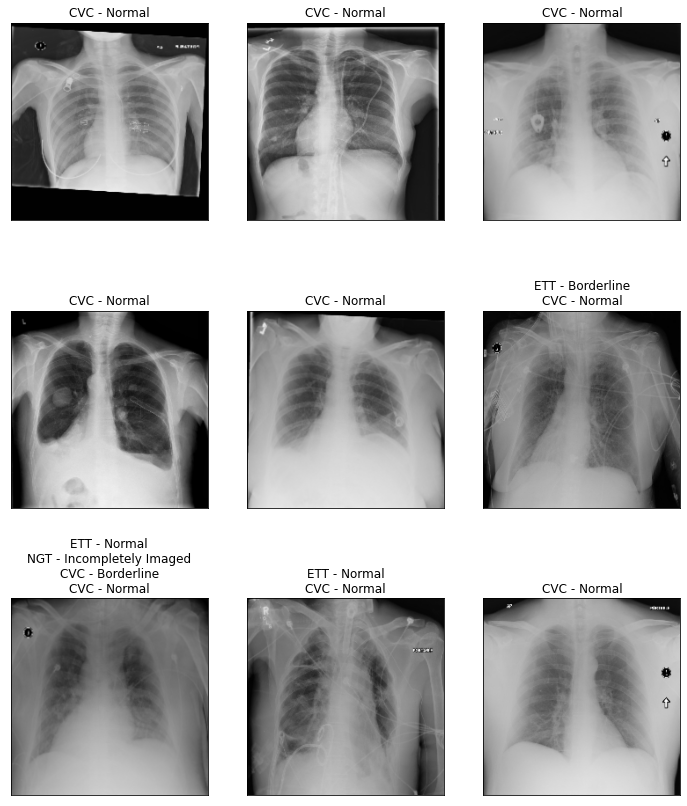

In [ ]:
display_batch(next(train_datagen))

# Building the Model

In [ ]:
!pip3 install image-classifiers -q

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
densenet = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
densenet.trainable = False

inputs = densenet.inputs
x = densenet(inputs)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(all_labels), activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

29089792/29084464 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                11275     
Total params: 7,048,779
Trainable params: 11,275
Non-trainable params: 7,037,504
_________________________________________________________________


# Learning Rate

In [ ]:
class LRFinder:
    def __init__(self, model, lr_range=[1e-10, 1e1], beta=0.98, stop_factor=4):
        self.model = model
        self.lr_range = lr_range
        self.beta = beta
        self.stop_factor = stop_factor
        self.stop_training = False
        self.iterations = 0
        self.mvg_avg_loss = 0
        self.min_loss = 1e9
        self.lrs = []
        self.losses = []

    def _reset(self):
        self.stop_training = False
        self.iterations = 0
        self.mvg_avg_loss = 0
        self.min_loss = 1e9
        self.lrs = []
        self.losses = []

    def _scheduler(self, start_lr, end_lr, iterations):
        self.lr_factor = (end_lr / start_lr)**(1./iterations)

    def on_train_begin(self, logs=None):
        self._reset()

    def on_batch_end(self, batch, logs=None):
        self.iterations += 1

        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)
        tf.keras.backend.set_value(self.model.optimizer.lr, lr*self.lr_factor)

        loss = logs['loss']
        self.mvg_avg_loss = (self.beta*self.mvg_avg_loss) + ((1-self.beta)*loss)
        smooth_loss = self.mvg_avg_loss / (1-(self.beta**self.iterations))
        self.losses.append(smooth_loss)

        stop_loss = self.stop_factor * self.min_loss
        if self.iterations > 1 and smooth_loss > self.stop_factor:
            self.stop_training = True

        if self.iterations == 0 or smooth_loss < self.min_loss:
            self.min_loss = smooth_loss
            print(f'\nIterations: {self.iterations}, lr: {lr}, loss: {smooth_loss}/{loss}, lrf: {self.lr_factor}')

    def on_epoch_end(self, epoch, logs=None):
        if self.stop_training:
            self.model.stop_training = True
            return

    def find(self, train_ds, epochs=None, steps_per_epoch=None, batch_size=32):
        if epochs is None:
            raise ValueError(f'Invalid value {epochs} for epochs')

        if steps_per_epoch is None:
            steps_per_epoch = len(train_ds)
            
        self._scheduler(self.lr_range[0], self.lr_range[1], steps_per_epoch*epochs)

        with tempfile.NamedTemporaryFile(prefix='init', suffix='.h5') as init_config:
            # save model config
            self.model.save_weights(init_config.name)
            init_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
            
            tf.keras.backend.set_value(self.model.optimizer.lr, self.lr_range[0])

            lr_finder_cb = tf.keras.callbacks.LambdaCallback(
                on_train_begin= lambda logs: self.on_train_begin(logs),
                on_batch_end= lambda batch, logs: self.on_batch_end(batch, logs),
                on_epoch_end= lambda epoch, logs: self.on_epoch_end(epoch, logs)
            )

            self.model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch,
                           callbacks=[lr_finder_cb])

            # restore model config
            tf.keras.backend.set_value(self.model.optimizer.lr, init_lr)
            self.model.load_weights(init_config.name)

    def plot_loss(self, skip_begin=10, skip_end=1, title=""):
        lrs = self.lrs[skip_begin:-skip_end]
        losses = self.losses[skip_begin:-skip_end]
        plt.plot(lrs, losses)
        plt.xscale("log")
        plt.xlabel("Learning Rate (Log Scale)")
        plt.ylabel("Loss")

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy', tf.keras.metrics.AUC()])

lr_finder = LRFinder(model)
lr_finder.find(train_datagen, epochs=10)

Epoch 1/10
   1/1507 [..............................] - ETA: 2:39:42 - loss: 0.8838 - binary_accuracy: 0.4659 - auc: 0.5037
Iterations: 1, lr: 1.000000013351432e-10, loss: 0.8838104009628297/0.8838104009628296, lrf: 1.0016821322458567
1507/1507 [==============================] - 1198s 791ms/step - loss: 0.9136 - binary_accuracy: 0.4078 - auc: 0.4442
Epoch 2/10
1507/1507 [==============================] - 1166s 774ms/step - loss: 0.9142 - binary_accuracy: 0.4073 - auc: 0.4424
Epoch 3/10
1507/1507 [==============================] - 838s 555ms/step - loss: 0.9131 - binary_accuracy: 0.4092 - auc: 0.4432
Epoch 4/10
 634/1507 [===========>..................] - ETA: 8:01 - loss: 0.8898 - binary_accuracy: 0.4282 - auc: 0.4600
Iterations: 5155, lr: 5.781545837635349e-07, loss: 0.8837850530789169/0.8821300864219666, lrf: 1.0016821322458567
 635/1507 [===========>..................] - ETA: 8:00 - loss: 0.8897 - binary_accuracy: 0.4282 - auc: 0.4600
Iterations: 5156, lr: 5.791271178168245e-07, los

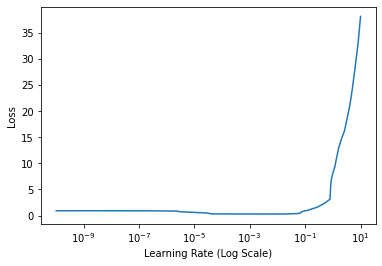

In [ ]:
lr_finder.plot_loss()

In [ ]:
def scale_fn(x):  return 1.

In [ ]:
clr = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=1e-5,
    maximal_learning_rate=1e-2,
    scale_fn=scale_fn,
    step_size=2*len(train_datagen)*BATCH_SIZE,
    scale_mode='cyclic'
)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=clr),
              loss='binary_crossentropy',
              metrics=['binary_accuracy', tf.keras.metrics.AUC()])

In [ ]:
model.fit(train_datagen, epochs=4, batch_size=BATCH_SIZE, 
          steps_per_epoch=len(train_datagen), 
          validation_data=valid_datagen,
          validation_steps=len(valid_datagen))

Epoch 1/4
1507/1507 [==============================] - 1539s 1s/step - loss: 0.2659 - binary_accuracy: 0.8906 - auc_2: 0.9014 - val_loss: 0.2595 - val_binary_accuracy: 0.8902 - val_auc_2: 0.9061
Epoch 2/4
1507/1507 [==============================] - 1195s 793ms/step - loss: 0.2594 - binary_accuracy: 0.8917 - auc_2: 0.9079 - val_loss: 0.2582 - val_binary_accuracy: 0.8898 - val_auc_2: 0.9064
Epoch 3/4
1507/1507 [==============================] - 996s 661ms/step - loss: 0.2515 - binary_accuracy: 0.8941 - auc_2: 0.9141 - val_loss: 0.2538 - val_binary_accuracy: 0.8906 - val_auc_2: 0.9100
Epoch 4/4
1507/1507 [==============================] - 995s 660ms/step - loss: 0.2497 - binary_accuracy: 0.8937 - auc_2: 0.9158 - val_loss: 0.2496 - val_binary_accuracy: 0.8908 - val_auc_2: 0.9141


In [ ]:
densenet.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                11275     
Total params: 7,048,779
Trainable params: 6,965,131
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
clr = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=1e-9,
    maximal_learning_rate=1e-4,
    scale_fn=scale_fn,
    step_size=2*len(train_datagen)*BATCH_SIZE,
    scale_mode='cyclic'
)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=clr),
              loss='binary_crossentropy',
              metrics=['binary_accuracy', tf.keras.metrics.AUC()])

In [ ]:
model.fit(train_datagen, epochs=4, batch_size=BATCH_SIZE, 
          steps_per_epoch=len(train_datagen), 
          validation_data=valid_datagen,
          validation_steps=len(valid_datagen))

Epoch 1/4
1507/1507 [==============================] - 6054s 4s/step - loss: 0.3044 - binary_accuracy: 0.8754 - auc_3: 0.8710 - val_loss: 0.2718 - val_binary_accuracy: 0.8832 - val_auc_3: 0.8969
Epoch 2/4
1507/1507 [==============================] - 5666s 4s/step - loss: 0.2651 - binary_accuracy: 0.8888 - auc_3: 0.9047 - val_loss: 0.2587 - val_binary_accuracy: 0.8891 - val_auc_3: 0.9093
Epoch 3/4
1507/1507 [==============================] - 5169s 3s/step - loss: 0.2427 - binary_accuracy: 0.8973 - auc_3: 0.9208 - val_loss: 0.2391 - val_binary_accuracy: 0.8968 - val_auc_3: 0.9232
Epoch 4/4
1507/1507 [==============================] - 5123s 3s/step - loss: 0.2262 - binary_accuracy: 0.9033 - auc_3: 0.9331 - val_loss: 0.2292 - val_binary_accuracy: 0.8977 - val_auc_3: 0.9294


In [ ]:
model.save('finetuned.h5')

In [ ]:
model = tf.keras.models.load_model('finetuned.h5',
                                   custom_objects={'scale_fn': scale_fn})

In [ ]:
test_files = {
    os.path.basename(f)[:-4] : f
    for f in glob.glob(str(path/'test'/'*.jpg'))
}

In [ ]:
test_df = pd.DataFrame({'StudyInstanceUID': list(test_files.keys()), 'path': list(test_files.values())})

In [ ]:
test_df.head()

,StudyInstanceUID,path
0,1.2.826.0.1.3680043.8.498.11696015398467113616...,/home/zhoo0005/sc73/ranzcr-clip-catheter-line-...
1,1.2.826.0.1.3680043.8.498.68384863107195565854...,/home/zhoo0005/sc73/ranzcr-clip-catheter-line-...
2,1.2.826.0.1.3680043.8.498.43865422761892279930...,/home/zhoo0005/sc73/ranzcr-clip-catheter-line-...
3,1.2.826.0.1.3680043.8.498.52954710593046311723...,/home/zhoo0005/sc73/ranzcr-clip-catheter-line-...
4,1.2.826.0.1.3680043.8.498.12399308137392515118...,/home/zhoo0005/sc73/ranzcr-clip-catheter-line-...


In [ ]:
def test_predictor(df, model):
    res = {
        l: []
        for l in all_labels
    }
    for f, p in df.values:
        img = tf.keras.preprocessing.image.load_img(p, target_size=(IMG_SIZE, IMG_SIZE))
        img = np.expand_dims(np.asarray(img)/225, axis=0)
        pred = model.predict(img).flatten()
        for i in range(len(all_labels)):
            res[all_labels[i]].append(pred[i])
    return res

res = test_predictor(test_df, model)

In [ ]:
r = pd.DataFrame(res)
submission = pd.concat([test_df['StudyInstanceUID'], r], axis=1)
submission.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.11696015398467113616...,0.000073,0.000560,0.000937,0.005676,0.003769,0.000314,0.016300,0.076292,0.255985,0.555073,0.000044
1,1.2.826.0.1.3680043.8.498.68384863107195565854...,0.000039,0.000328,0.001380,0.000641,0.001104,0.000435,0.001781,0.044628,0.082737,0.927087,0.000298
2,1.2.826.0.1.3680043.8.498.43865422761892279930...,0.000300,0.000362,0.000297,0.000718,0.001526,0.000300,0.000975,0.268563,0.507954,0.498548,0.000112
3,1.2.826.0.1.3680043.8.498.52954710593046311723...,0.000381,0.006914,0.017922,0.017592,0.014337,0.001784,0.117807,0.072589,0.354195,0.513722,0.000676
4,1.2.826.0.1.3680043.8.498.12399308137392515118...,0.000055,0.000256,0.021958,0.000311,0.002382,0.002858,0.001162,0.013623,0.294580,0.761909,0.000159


In [ ]:
model.evaluate(valid_datagen)

374/374 [==============================] - 179s 474ms/step - loss: 0.2292 - binary_accuracy: 0.8977 - auc_3: 0.9294


[0.22918277978897095, 0.8977253437042236, 0.9293584227561951]